In [1]:
import sys
sys.path.append('/home/aklantbhowmick/anaconda3/lib/python3.7/site-packages')
sys.path.append('/home/aklantbhowmick/anaconda3/lib/python3.7/site-packages/scalpy/')
sys.path.append('/home/aklantbhowmick/anaconda3/envs/nbodykit-env/lib/python3.6/site-packages/')
#sys.path.append('/home/aklantbhowmick/.local/lib/python3.12/site-packages/')
#sys.path.append('/home/aklantbhowmick/anaconda3/lib/python3.11//site-packages/')

import mdot_to_Lbol
import arepo_package
import scipy.interpolate
radiative_efficiency=0.2
total_conv=mdot_to_Lbol.get_conversion_factor_arepo(radiative_efficiency)
import h5py
import illustris_python as il
import numpy 
import pandas as pd
import scipy.integrate
from scipy.optimize import curve_fit
import os
%pylab inline

import numpy as np
from scipy.stats import gaussian_kde
from matplotlib.colors import LogNorm


title_fontsize=30
import warnings
warnings.filterwarnings("ignore")

import gwent
from scipy.integrate import quad
label_fontsize=40



c=3*10**5
path_to_output='/blue/lblecha/aklantbhowmick/CURRENT_RUNS2/L12p5n512/'
run='/AREPO/'
output= '/output_ratio10_SFMFGM5_seed5.00_bFOF_LW10_spin_rich/'
basePath=path_to_output+run+output
upto_redshift=0
omm=arepo_package.load_snapshot_header(basePath,upto_redshift)['Omega0']
oml=arepo_package.load_snapshot_header(basePath,upto_redshift)['OmegaLambda']
omk=0
hubble=arepo_package.load_snapshot_header(basePath,upto_redshift)['HubbleParam']

Populating the interactive namespace from numpy and matplotlib
Desired redshift:  0
Output redshift:  2.220446049250313e-16
Output snapshot:  32
{'BoxSize': 12500.0, 'Composition_vector_length': 0, 'Flag_Cooling': 1, 'Flag_DoublePrecision': 0, 'Flag_Feedback': 1, 'Flag_Metals': 0, 'Flag_Sfr': 1, 'Flag_StellarAge': 0, 'Git_commit': b'e9248873f6fabf87d52c75937a7e11a479b2847d', 'Git_date': b'Thu Sep 9 12:15:43 2021 -0400', 'HubbleParam': 0.6771, 'MassTable': array([0.        , 0.00010512, 0.        , 0.        , 0.        ,
       0.        ]), 'NumFilesPerSnapshot': 16, 'NumPart_ThisFile': array([7497374, 8189494,       0,       0, 1106072,      15], dtype=int32), 'NumPart_Total': array([120470319, 134217728,         0,         0,  14712222,       124],
      dtype=uint32), 'NumPart_Total_HighWord': array([0, 0, 0, 0, 0, 0], dtype=uint32), 'Omega0': 0.3089, 'OmegaBaryon': 0.0486, 'OmegaLambda': 0.6911, 'Redshift': 2.220446049250313e-16, 'Time': 0.9999999999999998, 'UnitLength_in_cm': 3.0

In [2]:
def DC(z0, z1):
    # Comoving distance in Mpc                                                                                          $
    def integrand(z):
        return 1.0/E(z)
    return c/(100.0)*quad(integrand,z0,z1)[0]

def dx_dz(z):
    # Comoving distance in Mpc                                                                                          $
    def integrand(z):
        return 1.0/E(z)
    return c/(100.0)*integrand(z)


def E(z):
        #normalized hubble parameter                                                                                    $
    return np.sqrt(omm*(1.0+z)**3 + oml + omk*(1.0+z)**2)

def DL(z):
    #Luminosity distance in Mpcs                                                                                        $
    return (1.0+z)*DC(0,z)

def DM(z):
        #Distance Modulus                                                                                               $
        return 5*np.log10((DL(z)*1e6)/10.0)

def mtoM(m,z):
    return m - DM(z) - K(z)

def Mtom(M, z):
    return M + DM(z) + K(z)

def LtoM(L):
    M = -2.5 * np.log10(L*1e-7)+34.1
    return M

def MtoL(M):
    return 10**((-1/2.5*(M-34.1)))*1e7

def K(z):
    #K correction, assuming same filter size in emitted and observed frame                                              $
    return 2.5*np.log10(1.0/(1+z))

def T(z0,z1):
    sectoyrs=3.171e-08
    Mpctokm=3.0857E+19
    def integrand(z):
        return 1.0/E(z)/(1+z)
    return 1./(100.0)*quad(integrand,z0,z1)[0]*Mpctokm*sectoyrs



In [3]:
def get_merger_distributions(basePath,nbins=20,min_value=0,max_value=25,linear=0,SNR_cut=0):
        mask_total_mass, mass_ratio, merger_redshifts, SNRs=numpy.load(basePath+'./SNRs_for_merger_events_zero_spin.npy')
        mask=SNRs>SNR_cut
        merger_redshifts=merger_redshifts[mask]
        bins, dist, dist_err,norm,counts_sum=arepo_package.get_probability_density(merger_redshifts,nbins,min_value,max_value,linear=linear) 
        dist*=counts_sum
        dist_err*=counts_sum
        dt=numpy.array([T(zz-norm/2,zz+norm/2) for zz in bins])
        dz=numpy.diff(bins)[0]
        dz_dt=numpy.array([dz/T(zz-dz/2,zz+dz/2) for zz in bins])   
        return bins,dist,dist_err,norm,dz_dt

def merger_rates(basePath,nbins=20,min_value=0,max_value=25,SNR_cut=0):
        bins,dist,dist_err,norm,dz_dt=get_merger_distributions(basePath,nbins=nbins,min_value=min_value,max_value=max_value,linear=1,SNR_cut=SNR_cut)
        volume_of_redshift_shell=numpy.array([4*3.14*DC(0,z_bin)**2*dx_dz(z_bin) for z_bin in bins])
        simulation_volume=(arepo_package.get_box_size(basePath)/1000)**3
        merger_rate=dist*1.
        merger_rate_err=dist_err*1.
        merger_rate*=dz_dt
        merger_rate_err*=dz_dt
        merger_rate/=simulation_volume
        merger_rate_err/=simulation_volume
        merger_rate*=volume_of_redshift_shell
        merger_rate_err*=volume_of_redshift_shell
        merger_rate/=(1+bins)
        merger_rate_err/=(1+bins)
        merger_rate2=dist*dz_dt/(1+bins)*volume_of_redshift_shell/simulation_volume
        merger_rate_err2=dist_err*dz_dt/(1+bins)*volume_of_redshift_shell/simulation_volume
        return bins, merger_rate2,merger_rate_err2


In [4]:
global kde
# Generate random events from the estimated KDE
def generate_events(number_of_events=0,get_number_of_events_from_user=0,use_unweighted=0,SNR_cut=0):
    kde, kde_no_weight, LogMass_total, LogMass_ratio, Redshift,n = get_samples(number_of_events=number_of_events,get_number_of_events_from_user=get_number_of_events_from_user,SNR_cut=SNR_cut)
    # Use the resample method to generate random samples
    if(use_unweighted==1):
        samples = kde_no_weight.resample(size=n)
    else:
        samples = kde.resample(size=n)
    
    # Transpose the samples to get arrays of Mass_total, Mass_ratio, Redshift, and SNRs
    log_mass_total = samples[0]
    log_mass_ratio = samples[1]
    redshift = samples[2]
    return log_mass_total, log_mass_ratio, redshift, LogMass_total, LogMass_ratio, Redshift

def get_samples(number_of_events=0,get_number_of_events_from_user=0,SNR_cut=0):
    #scale_fac_complete_sorted,primary_mass_sorted,secondary_mass_sorted,primary_id_sorted,secondary_id_sorted,file_id_complete_sorted,N_empty=arepo_package.get_merger_events_from_snapshot(basePath,upto_redshift,HOSTS=0)
    # Assuming Mass_total, Mass_ratio, Redshift, and SNRs are numpy arrays
    Mass_total, Mass_ratio, Redshift, SNRs=numpy.load(basePath+'./SNRs_for_merger_events_zero_spin.npy')
    mask=SNRs > SNR_cut

        
    
    LogMass_total=numpy.log10(Mass_total[mask])
    LogMass_ratio=numpy.log10(Mass_ratio[mask])
    Redshift=Redshift[mask]
    # Stack the input arrays vertically to get an array of shape (N, 3)
    data = np.vstack((LogMass_total, LogMass_ratio, Redshift))

    weights1 = numpy.array([1]*len(LogMass_total))
    weights2 = numpy.array([1]*len(LogMass_ratio))
    weights3 = numpy.array([1]*len(LogMass_ratio))


    weights3=numpy.array([4*3.14*DC(0,z_bin)**2*dx_dz(z_bin) for z_bin in Redshift])
    dz_dt=numpy.array([dz/T(zz-dz/2,zz+dz/2) for zz in Redshift])
    weights3=weights3*dz_dt/(1.+ Redshift)

    #weights3 =Redshift**6
    # Estimate the kernel density
    kde_no_weight = gaussian_kde(data,weights=weights2)
    kde = gaussian_kde(data,weights=weights3)
    if(get_number_of_events_from_user==0):
        n=len(LogMass_total)
    else:
        n=number_of_events

    return kde,kde_no_weight,LogMass_total, LogMass_ratio, Redshift,n



Total number of mergers per year: 131


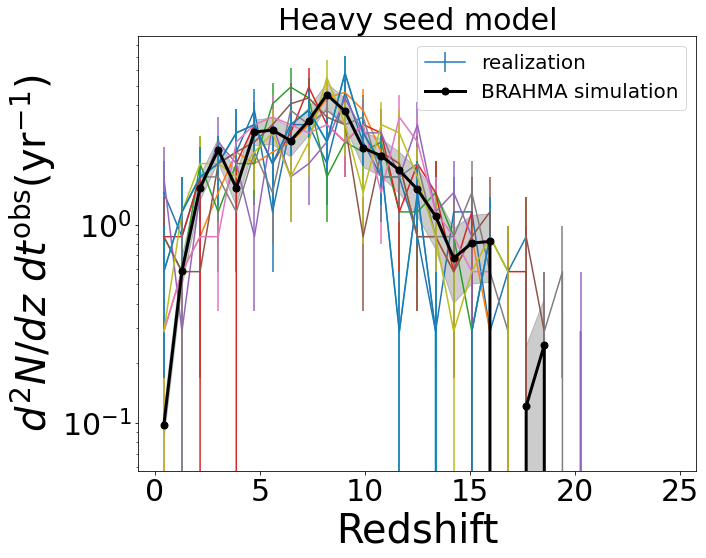

In [36]:



#---------------------Key knobs that related to the realization generations
SNR_cut=5
get_number_of_events_from_user=1
LISA_time_frame=4
number_of_realizations=10


#-------------------Knobs for binning the merger events in redshift space for integration and plotting
nbins=30
min_value=0
max_value=25
upto_redshift=0


#------------------Other internal inconsequential knobs
dz=0.001
use_unweighted=0



path_to_output='/blue/lblecha/aklantbhowmick/CURRENT_RUNS2/L12p5n512/'
run='/AREPO/'
output= '/output_ratio10_SFMFGM5_seed5.00_bFOF_LW10_spin_rich/'
basePath=path_to_output+run+output



labl=''
width=3
fstyle='solid'
mark='o'

f,ax=plt.subplots(1,1,figsize=(10,8),sharey=True,sharex=True)
ax.set_title('Heavy seed model',fontsize=30)
bins, merger_rate2,merger_rate_err2=merger_rates(basePath,nbins=nbins,min_value=min_value,max_value=max_value,SNR_cut=SNR_cut)
mask=bins>0
mergers_per_year=scipy.integrate.trapz(merger_rate2[mask],bins[mask])
number_of_events=int(mergers_per_year*LISA_time_frame)
print("Total number of mergers per year:",number_of_events)
for ii in range(0,number_of_realizations):
    log_mass_total_events, log_mass_ratio_events, redshift_events, LogMass_total_original, LogMass_ratio_original, Redshift_original = generate_events(number_of_events=number_of_events,get_number_of_events_from_user=get_number_of_events_from_user,use_unweighted=use_unweighted,SNR_cut=SNR_cut)
    bins, dist, dist_err,norm,counts_sum=arepo_package.get_probability_density(redshift_events,nbins,min_value,max_value,linear=1) 
    ax.errorbar(bins,dist*counts_sum/LISA_time_frame,dist_err*counts_sum/LISA_time_frame)

ax.errorbar(bins,dist*counts_sum/LISA_time_frame,dist_err*counts_sum/LISA_time_frame,label='realization')

    
col='black'    

ax.errorbar(bins[mask],merger_rate2[mask],label='BRAHMA simulation',linewidth=width,color=col,linestyle=fstyle,marker=mark,ms=7)
ax.fill_between(bins[mask],merger_rate2[mask]+merger_rate_err2[mask],merger_rate2[mask]-merger_rate_err2[mask],color=col,alpha=0.2)

ax.legend(loc='upper right',fontsize=20)
ax.tick_params(labelsize=30)
ax.set_ylabel('$d^2 N/dz \ dt^{\mathrm{obs}}(\mathrm{yr}^{-1})$',fontsize=40)
ax.set_xlabel('Redshift',fontsize=40)
ax.set_yscale('log')

Total number of mergers per year: 197


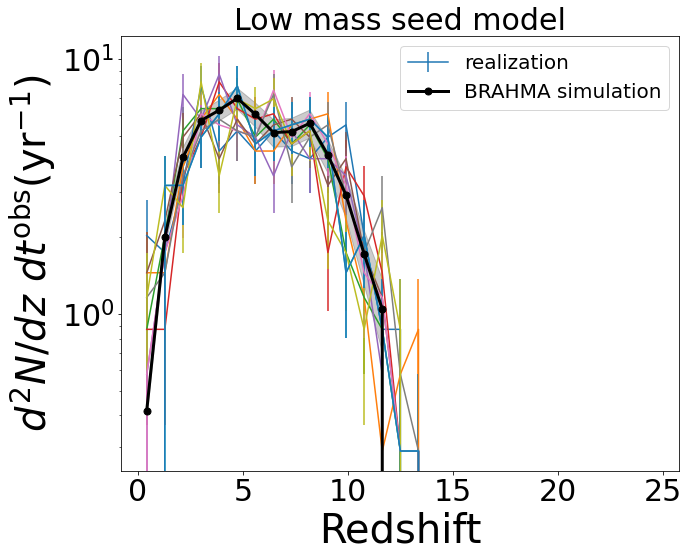

In [35]:



#---------------------Key knobs that related to the realization generations
SNR_cut=5
get_number_of_events_from_user=1
LISA_time_frame=4
number_of_realizations=10


#-------------------Knobs for binning the merger events in redshift space for integration and plotting
nbins=30
min_value=0
max_value=25
upto_redshift=0


#------------------Other internal inconsequential knobs
dz=0.001
use_unweighted=0



Mh,Msfmp=1000,5
path_to_output='/orange/lblecha/aklantbhowmick/GAS_BASED_SEED_MODEL_UNIFORM_RUNS/L12p5n512//'
run='/AREPO/' # name of the simulation runs
output='/output_Msfmp%d_Mh%d_double_powerlaw_env_5_0.1_0.3_slope1.6/'%(Msfmp,Mh)
basePath=path_to_output+run+output



labl=''
width=3
fstyle='solid'
mark='o'

f,ax=plt.subplots(1,1,figsize=(10,8),sharey=True,sharex=True)
ax.set_title('Low mass seed model',fontsize=30)
bins, merger_rate2,merger_rate_err2=merger_rates(basePath,nbins=nbins,min_value=min_value,max_value=max_value,SNR_cut=SNR_cut)
mask=bins>0
mergers_per_year=scipy.integrate.trapz(merger_rate2[mask],bins[mask])
number_of_events=int(mergers_per_year*LISA_time_frame)
print("Total number of mergers per year:",number_of_events)
for ii in range(0,number_of_realizations):
    log_mass_total_events, log_mass_ratio_events, redshift_events, LogMass_total_original, LogMass_ratio_original, Redshift_original = generate_events(number_of_events=number_of_events,get_number_of_events_from_user=get_number_of_events_from_user,use_unweighted=use_unweighted,SNR_cut=SNR_cut)
    bins, dist, dist_err,norm,counts_sum=arepo_package.get_probability_density(redshift_events,nbins,min_value,max_value,linear=1) 
    ax.errorbar(bins,dist*counts_sum/LISA_time_frame,dist_err*counts_sum/LISA_time_frame)

ax.errorbar(bins,dist*counts_sum/LISA_time_frame,dist_err*counts_sum/LISA_time_frame,label='realization')

    
col='black'    

ax.errorbar(bins[mask],merger_rate2[mask],label='BRAHMA simulation',linewidth=width,color=col,linestyle=fstyle,marker=mark,ms=7)
ax.fill_between(bins[mask],merger_rate2[mask]+merger_rate_err2[mask],merger_rate2[mask]-merger_rate_err2[mask],color=col,alpha=0.2)

ax.legend(loc='upper right',fontsize=20)
ax.tick_params(labelsize=30)
ax.set_ylabel('$d^2 N/dz \ dt^{\mathrm{obs}}(\mathrm{yr}^{-1})$',fontsize=40)
ax.set_xlabel('Redshift',fontsize=40)
ax.set_yscale('log')

Total number of mergers: 98
Total number of mergers: 65
Total number of mergers: 197
Total number of mergers: 131
Total number of mergers: 394
Total number of mergers: 262
Total number of mergers: 788
Total number of mergers: 525


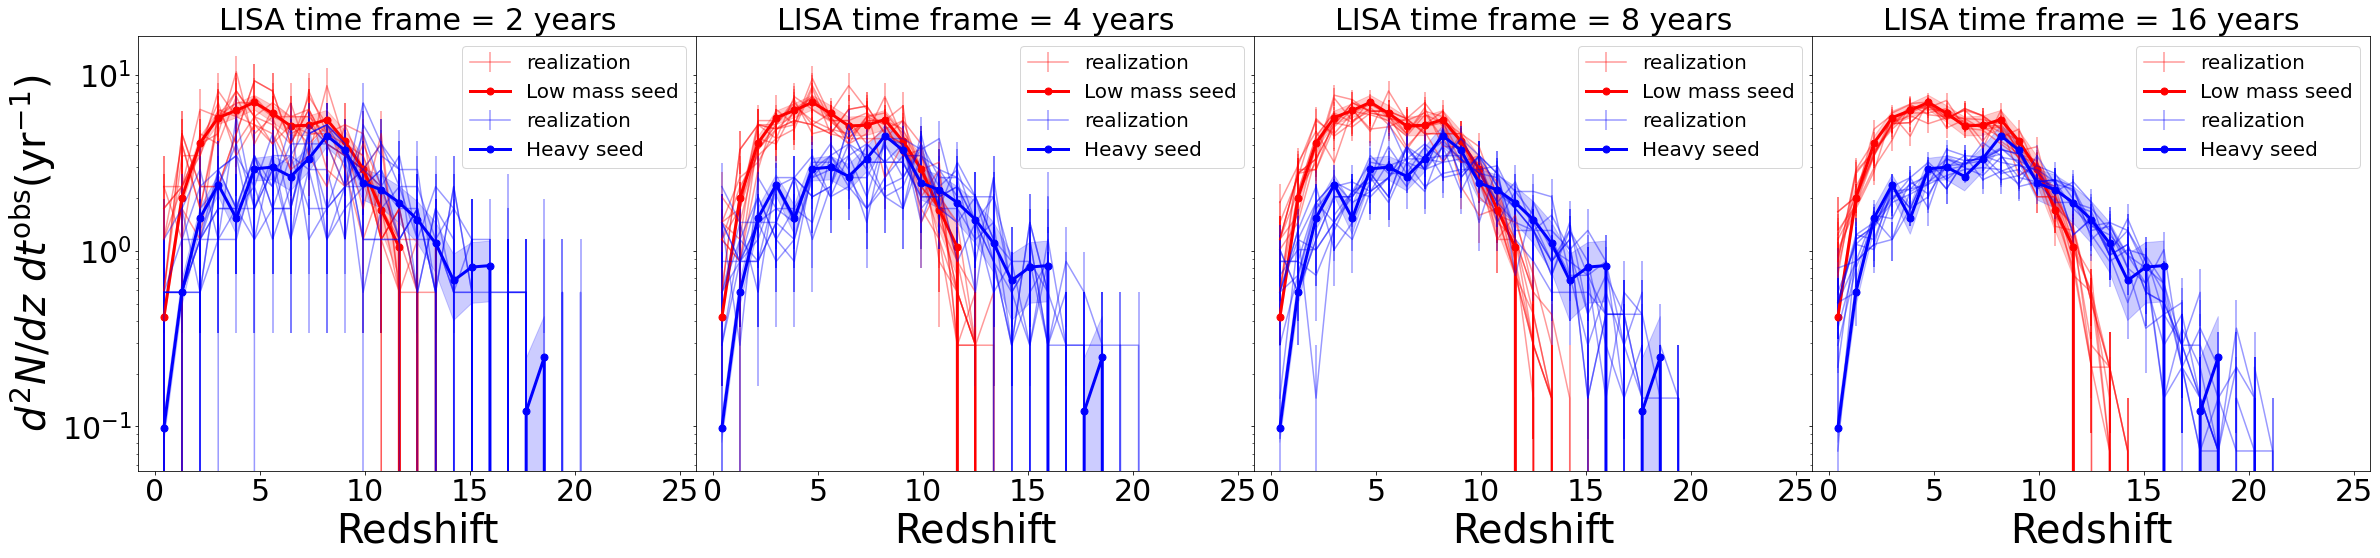

In [46]:
def make_plot(labl=''):
    #labl=''
    width=3
    fstyle='solid'
    mark='o' 


    #ax.set_title('Low mass seed model',fontsize=30)
    bins, merger_rate2,merger_rate_err2=merger_rates(basePath,nbins=nbins,min_value=min_value,max_value=max_value,SNR_cut=SNR_cut)
    mask=bins>0
    mergers_per_year=scipy.integrate.trapz(merger_rate2[mask],bins[mask])
    number_of_events=int(mergers_per_year*LISA_time_frame)
    print("Total number of mergers:",number_of_events)
    for ii in range(0,number_of_realizations):
        log_mass_total_events, log_mass_ratio_events, redshift_events, LogMass_total_original, LogMass_ratio_original, Redshift_original = generate_events(number_of_events=number_of_events,get_number_of_events_from_user=get_number_of_events_from_user,use_unweighted=use_unweighted,SNR_cut=SNR_cut)
        bins, dist, dist_err,norm,counts_sum=arepo_package.get_probability_density(redshift_events,nbins,min_value,max_value,linear=1) 
        ax.errorbar(bins,dist*counts_sum/LISA_time_frame,dist_err*counts_sum/LISA_time_frame,color=col,alpha=0.4)

    ax.errorbar(bins,dist*counts_sum/LISA_time_frame,dist_err*counts_sum/LISA_time_frame,label='realization',color=col,alpha=0.4)



    ax.errorbar(bins[mask],merger_rate2[mask],label=labl,linewidth=width,color=col,linestyle=fstyle,marker=mark,ms=7)
    ax.fill_between(bins[mask],merger_rate2[mask]+merger_rate_err2[mask],merger_rate2[mask]-merger_rate_err2[mask],color=col,alpha=0.2)



#---------------------Key knobs that related to the realization generations
SNR_cut=5
get_number_of_events_from_user=1
LISA_time_frame=4
number_of_realizations=10


#-------------------Knobs for binning the merger events in redshift space for integration and plotting
nbins=30
min_value=0
max_value=25
upto_redshift=0


#------------------Other internal inconsequential knobs
dz=0.001
use_unweighted=0

ii=0
f,axx=plt.subplots(1,4,figsize=(40,8),sharey=True,sharex=True)

for LISA_time_frame in [2,4,8,16]:
    ax=axx[ii]
    ax.set_title('LISA time frame = %d years'%LISA_time_frame,fontsize=30)
    Mh,Msfmp=1000,5
    path_to_output='/orange/lblecha/aklantbhowmick/GAS_BASED_SEED_MODEL_UNIFORM_RUNS/L12p5n512//'
    run='/AREPO/' # name of the simulation runs
    output='/output_Msfmp%d_Mh%d_double_powerlaw_env_5_0.1_0.3_slope1.6/'%(Msfmp,Mh)
    basePath=path_to_output+run+output
    col='red'
    make_plot(labl='Low mass seed')


    path_to_output='/blue/lblecha/aklantbhowmick/CURRENT_RUNS2/L12p5n512/'
    run='/AREPO/'
    output= '/output_ratio10_SFMFGM5_seed5.00_bFOF_LW10_spin_rich/'
    basePath=path_to_output+run+output
    col='blue'
    make_plot(labl='Heavy seed')


    ax.legend(loc='upper right',fontsize=20)
    ax.tick_params(labelsize=30)
   
    ax.set_xlabel('Redshift',fontsize=40)
    ax.set_yscale('log')
    ii+=1
axx[0].set_ylabel('$d^2 N/dz \ dt^{\mathrm{obs}}(\mathrm{yr}^{-1})$',fontsize=40)
plt.subplots_adjust(wspace=0)




Total number of mergers: 197
Total number of mergers: 131
Total number of mergers: 153
Total number of mergers: 124
Total number of mergers: 94
Total number of mergers: 71
Total number of mergers: 16
Total number of mergers: 11


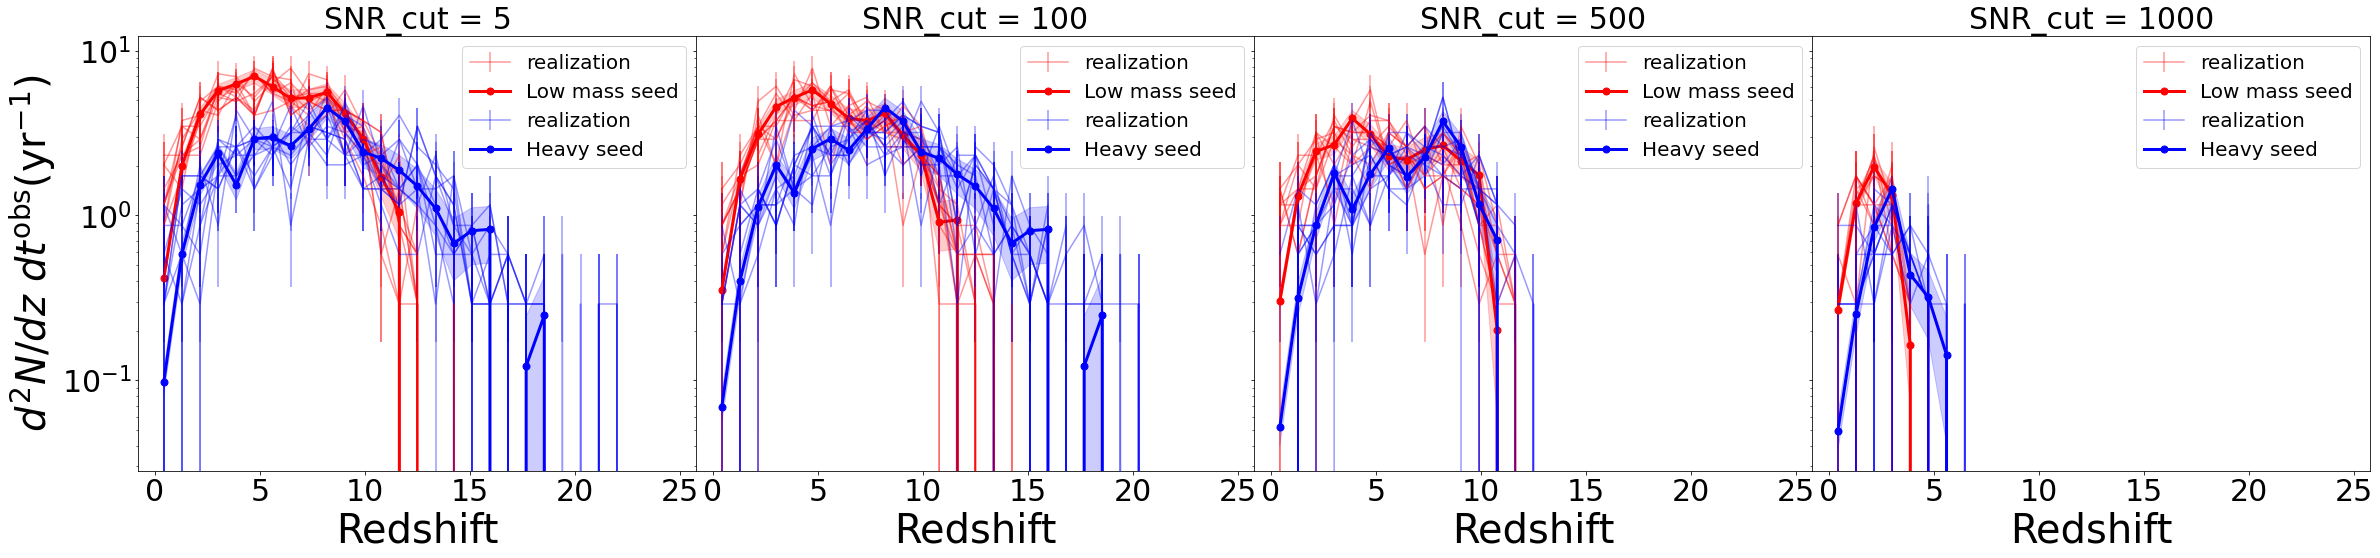

In [52]:
def make_plot(labl=''):
    #labl=''
    width=3
    fstyle='solid'
    mark='o' 


    #ax.set_title('Low mass seed model',fontsize=30)
    bins, merger_rate2,merger_rate_err2=merger_rates(basePath,nbins=nbins,min_value=min_value,max_value=max_value,SNR_cut=SNR_cut)
    mask=bins>0
    mergers_per_year=scipy.integrate.trapz(merger_rate2[mask],bins[mask])
    number_of_events=int(mergers_per_year*LISA_time_frame)
    print("Total number of mergers:",number_of_events)
    for ii in range(0,number_of_realizations):
        log_mass_total_events, log_mass_ratio_events, redshift_events, LogMass_total_original, LogMass_ratio_original, Redshift_original = generate_events(number_of_events=number_of_events,get_number_of_events_from_user=get_number_of_events_from_user,use_unweighted=use_unweighted,SNR_cut=SNR_cut)
        bins, dist, dist_err,norm,counts_sum=arepo_package.get_probability_density(redshift_events,nbins,min_value,max_value,linear=1) 
        ax.errorbar(bins,dist*counts_sum/LISA_time_frame,dist_err*counts_sum/LISA_time_frame,color=col,alpha=0.4)

    ax.errorbar(bins,dist*counts_sum/LISA_time_frame,dist_err*counts_sum/LISA_time_frame,label='realization',color=col,alpha=0.4)



    ax.errorbar(bins[mask],merger_rate2[mask],label=labl,linewidth=width,color=col,linestyle=fstyle,marker=mark,ms=7)
    ax.fill_between(bins[mask],merger_rate2[mask]+merger_rate_err2[mask],merger_rate2[mask]-merger_rate_err2[mask],color=col,alpha=0.2)



#---------------------Key knobs that related to the realization generations
SNR_cut=5
get_number_of_events_from_user=1
LISA_time_frame=4
number_of_realizations=10


#-------------------Knobs for binning the merger events in redshift space for integration and plotting
nbins=30
min_value=0
max_value=25
upto_redshift=0


#------------------Other internal inconsequential knobs
dz=0.001
use_unweighted=0

ii=0
f,axx=plt.subplots(1,4,figsize=(40,8),sharey=True,sharex=True)

for SNR_cut in [5,100,500,1000]:
    ax=axx[ii]
    ax.set_title('SNR_cut = %d'%SNR_cut,fontsize=30)
    Mh,Msfmp=1000,5
    path_to_output='/orange/lblecha/aklantbhowmick/GAS_BASED_SEED_MODEL_UNIFORM_RUNS/L12p5n512//'
    run='/AREPO/' # name of the simulation runs
    output='/output_Msfmp%d_Mh%d_double_powerlaw_env_5_0.1_0.3_slope1.6/'%(Msfmp,Mh)
    basePath=path_to_output+run+output
    col='red'
    make_plot(labl='Low mass seed')


    path_to_output='/blue/lblecha/aklantbhowmick/CURRENT_RUNS2/L12p5n512/'
    run='/AREPO/'
    output= '/output_ratio10_SFMFGM5_seed5.00_bFOF_LW10_spin_rich/'
    basePath=path_to_output+run+output
    col='blue'
    make_plot(labl='Heavy seed')


    ax.legend(loc='upper right',fontsize=20)
    ax.tick_params(labelsize=30)
   
    ax.set_xlabel('Redshift',fontsize=40)
    ax.set_yscale('log')
    ii+=1
axx[0].set_ylabel('$d^2 N/dz \ dt^{\mathrm{obs}}(\mathrm{yr}^{-1})$',fontsize=40)
plt.subplots_adjust(wspace=0)




-----
1000 5
32 2.220446049250313e-16
Total number of mergers 601


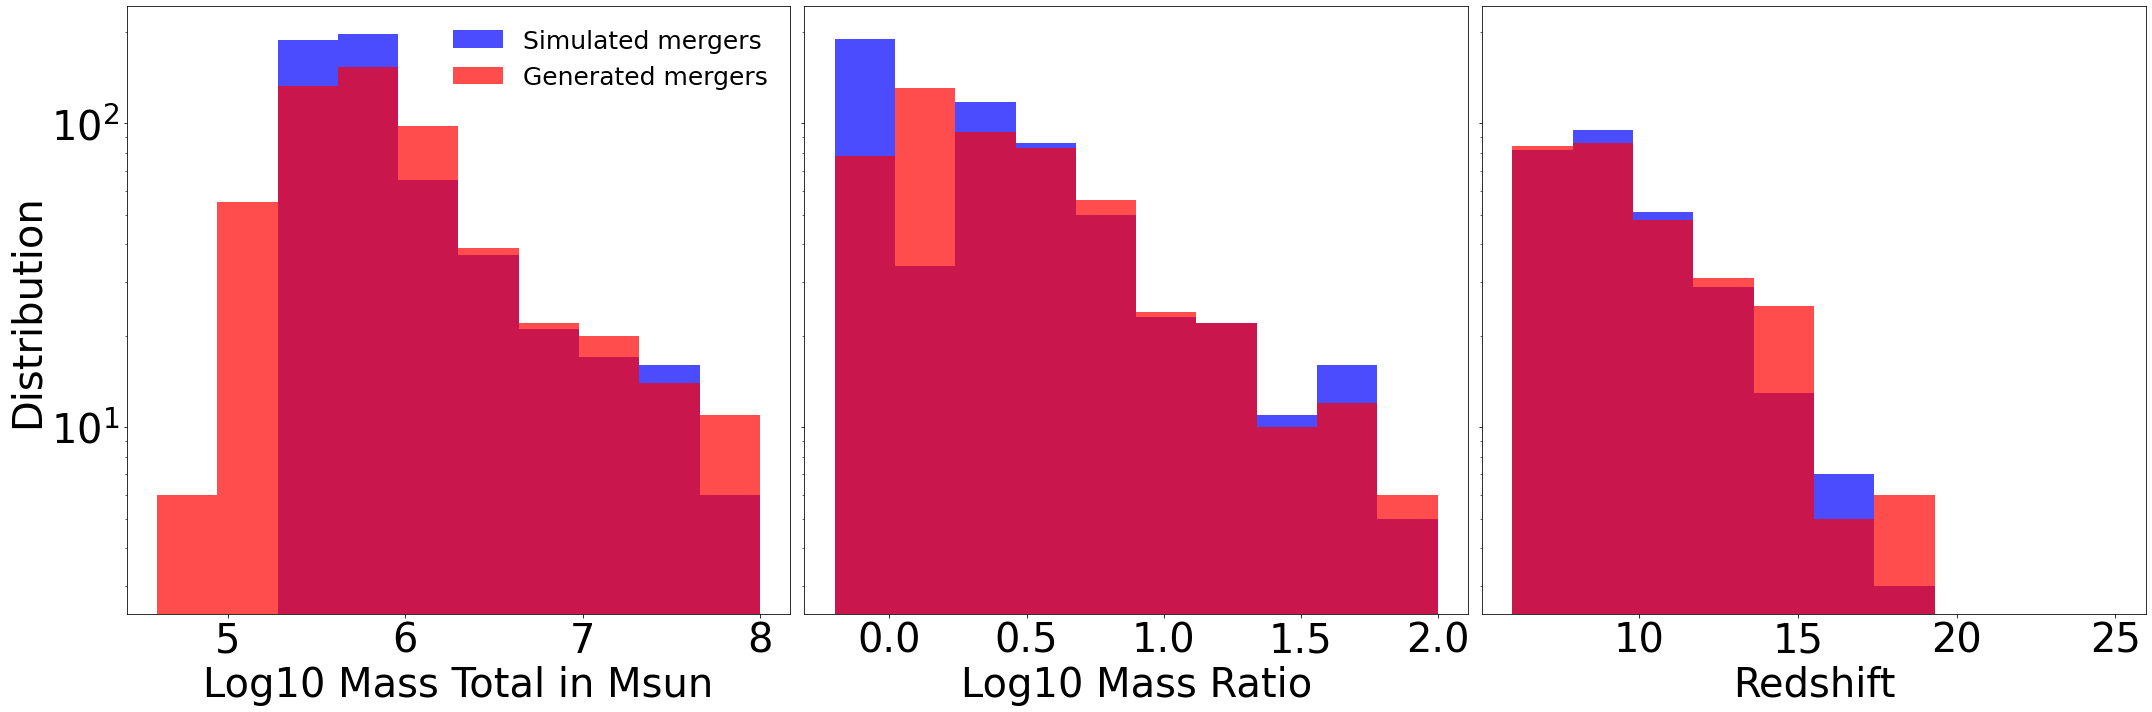

In [17]:
dz=0.001
use_unweighted=1
get_number_of_events_from_user=0
number_of_events=1000

SNR_cut=5

Mh,Msfmp=1000,5
print("-----")
print(Mh,Msfmp)

path_to_output='/blue/lblecha/aklantbhowmick/CURRENT_RUNS2/L12p5n512/'
run='/AREPO/'
output= '/output_ratio10_SFMFGM5_seed5.00_bFOF_LW10_spin_rich/'
basePath=path_to_output+run+output
upto_redshift=0
# Specify the number of events you want to generate
log_mass_total_events, log_mass_ratio_events, redshift_events, LogMass_total_original, LogMass_ratio_original, Redshift_original = generate_events(number_of_events=number_of_events,get_number_of_events_from_user=get_number_of_events_from_user,use_unweighted=use_unweighted,SNR_cut=SNR_cut)

fig, axs = plt.subplots(1, 3, figsize=(30, 10),sharey=True)


axs[0].hist(LogMass_total_original, bins=10, color='blue', alpha=0.7,range=(4.6,8),label='Simulated mergers')
axs[0].hist(log_mass_total_events, bins=10, color='red', alpha=0.7,range=(4.6,8),label='Generated mergers')


axs[1].hist(LogMass_ratio_original, bins=10, color='blue', alpha=0.7,range=(-0.2,2))
axs[1].hist(log_mass_ratio_events, bins=10, color='red', alpha=0.7,range=(-0.2,2))

axs[2].hist(Redshift_original, bins=10, color='blue', alpha=0.7,range=(6,25))
axs[2].hist(redshift_events, bins=10, color='red', alpha=0.7,range=(6,25))


axs[2].set_xlabel('Redshift',fontsize=40)
axs[1].set_xlabel('Log10 Mass Ratio',fontsize=40)
axs[0].set_xlabel('Log10 Mass Total in Msun',fontsize=40)


axs[0].set_ylabel('Distribution',fontsize=40)


axs[0].set_yscale('log')
axs[1].set_yscale('log')
axs[2].set_yscale('log')

axs[0].tick_params(labelsize=40)
axs[1].tick_params(labelsize=40)
axs[2].tick_params(labelsize=40)

axs[0].legend(loc='upper right',fontsize=25,frameon=False)

plt.tight_layout()
plt.show()

